In [1]:
import pandas as pd
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 512  #1024 didsn't work so well
LEARNING_RATE = 1e-5  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot'
# LAMBDA_IDENTITY = 0.1
LAMBDA_CYCLE = 10.0 # try out different values
NUM_WORKERS = 10
NUM_EPOCHS = 2000
LR_DECAY_AFTER_EPOCH = 800
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
LOAD_MODEL = False
SAVE_MODEL = False
SIG_A = "AoP" # "VADcurrent" # "VadQ" # "AoP" # "LVP"  
SIG_B = "VadQ" # "LVtot" # "LVtot_kalibriert" # "LVtot" # "LVtot_kalibriert" 
TARGET = "LVtot_kalibriert" 
CHECKPOINT_GEN_A2B = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_B)
CHECKPOINT_GEN_B2A = "Checkpoints/Generated_data/gen_{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_A =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_A)
CHECKPOINT_DISC_B =  "Checkpoints/Generated_data/disc{}.pth.tar".format(SIG_B)

## Dataset
### Load data from csv

In [3]:
# path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  # time: ~ 35 sec
# path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
# path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
# path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

def load_csv(path):
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, sep=";")
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [4]:
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/"
df = load_csv(path)
df = df.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])
print(df.shape)
print(type(df)) # <class 'pandas.core.frame.DataFrame'>

(8120300, 13)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
df_1 = load_csv(path_1)
# drop columns that are not needed
df_1 = df_1.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])


df_2 = load_csv(path_2)
df_2 = df_2.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])



df_3 = load_csv(path_3)
df_3 = df_3.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])



df_4 = load_csv(path_4)
df_4 = df_4.drop(columns=['Time',  'RVP', 'PaP', 'PaQ', 'ECGcond', 'Looperkennung', 'Extrasystolen', 'Ansaugphase', 'ECG', 'ECGcond', 'LVV1', 'LVV2', 
                      'LVV3', 'LVV4', 'LVV5', 'RVV1', 'RVV2', 'RVV3', 'RVV4', 'RVV5', 'Versuchsdatum', 'rep_an', 'rep_sect', 'contractility', 
                      'preload', 'afterload', 'controller'])

df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)

df = df.dropna()

# select only rows where 'Phasenzuordnung' is 1
df = df.loc[df['Phasenzuordnung'] == 1]

print(df.shape) # (7508420, 13)

## Preprocesssing
### Removing strings from the data

In [5]:
df_cols = df_cols = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 'VADcurrent', 'Phasenzuordnung', 
           'LVtot', 'RVtot', 'animal', 'intervention']

# convert to numpy array
df = df.to_numpy()

# iterate over rows and columns of numpy array
for row in range(df.shape[0]):
    for col in range(df.shape[1]):
        # if type is string, convert to float
        if type(df[row, col]) == str:
            df[row, col] = df[row, col].replace('[ml]', '')
            df[row, col] = df[row, col].replace('[mmHg]', '')
            df[row, col] = df[row, col].replace('[L/min]', '')
            df[row, col] = df[row, col].replace('[rpm]', '')
            df[row, col] = df[row, col].replace('[A]', '')
            df[row, col] = df[row, col].replace('[mL]', '')
            df[row, col] = float(df[row, col])

# convert back to dataframe
df = pd.DataFrame(df, columns=df_cols)

### Subsample the data by the factor 10

In [6]:
columns = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 
            'VADcurrent', 'Phasenzuordnung', 'LVtot', 'RVtot', 'animal', 'intervention']

arr = df.to_numpy()

def groupedAvg(myArray, N=2):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

print(arr.shape)
arr = groupedAvg(arr, N=10)
print(arr.shape)


df = pd.DataFrame(arr, columns=columns)

# add column names to df_train and df_test
df.columns = columns

# colums animal and intervention should be integers
df['animal'] = df['animal'].astype(int)
df['intervention'] = df['intervention'].astype(int)
print(df.head())

(8120300, 13)
(812030, 13)
   LVtot_kalibriert        LVP        AoP       AoQ  RVtot_kalibriert  \
0        136.945911  43.733307  45.496507  0.239615         80.628530   
1        136.119152  46.546286  45.325503  0.378293         79.387186   
2        135.101828  48.622489  45.933186  0.812218         77.954111   
3        133.813449  50.307336  46.975143  1.447258         76.520033   
4        132.431854  51.633226  47.927148  2.155005         75.424020   

    VADspeed      VadQ  VADcurrent  Phasenzuordnung      LVtot      RVtot  \
0  3210.4180  2.250695    0.504613              1.0  159.38540  150.44051   
1  3208.6189  2.335473    0.524283              1.0  158.61787  149.52167   
2  3207.3879  2.432488    0.547356              1.0  157.67343  148.63791   
3  3205.2133  2.495627    0.556459              1.0  156.47734  147.50659   
4  3207.1537  2.570268    0.550951              1.0  155.19471  146.72090   

   animal  intervention  
0      11            10  
1      11          

### Normalize the data

In [7]:
# intervntion, Phasenzuordnung and animal should be in another dataframe before the data is normalized
df_IPA = df[['intervention', 'Phasenzuordnung', 'animal']]

# drop columns in original dataframe
df = df.drop(columns=['intervention', 'Phasenzuordnung', 'animal'])

# The data has to be array-like
df_cols = ['LVtot_kalibriert', 'LVP', 'AoP', 'AoQ', 'RVtot_kalibriert', 'VADspeed', 'VadQ', 'VADcurrent', 'LVtot', 'RVtot']
df = df.to_numpy()

# scale the data
scaler = StandardScaler()
scaler.fit(df)
transformed_data = scaler.transform(df)

df = pd.DataFrame(transformed_data, columns=df_cols)
# concatenate df and df_IPA
df = pd.concat([df, df_IPA], axis=1)
print(df.shape)

(812030, 13)


### Modulo 256

### Visualize some of the data

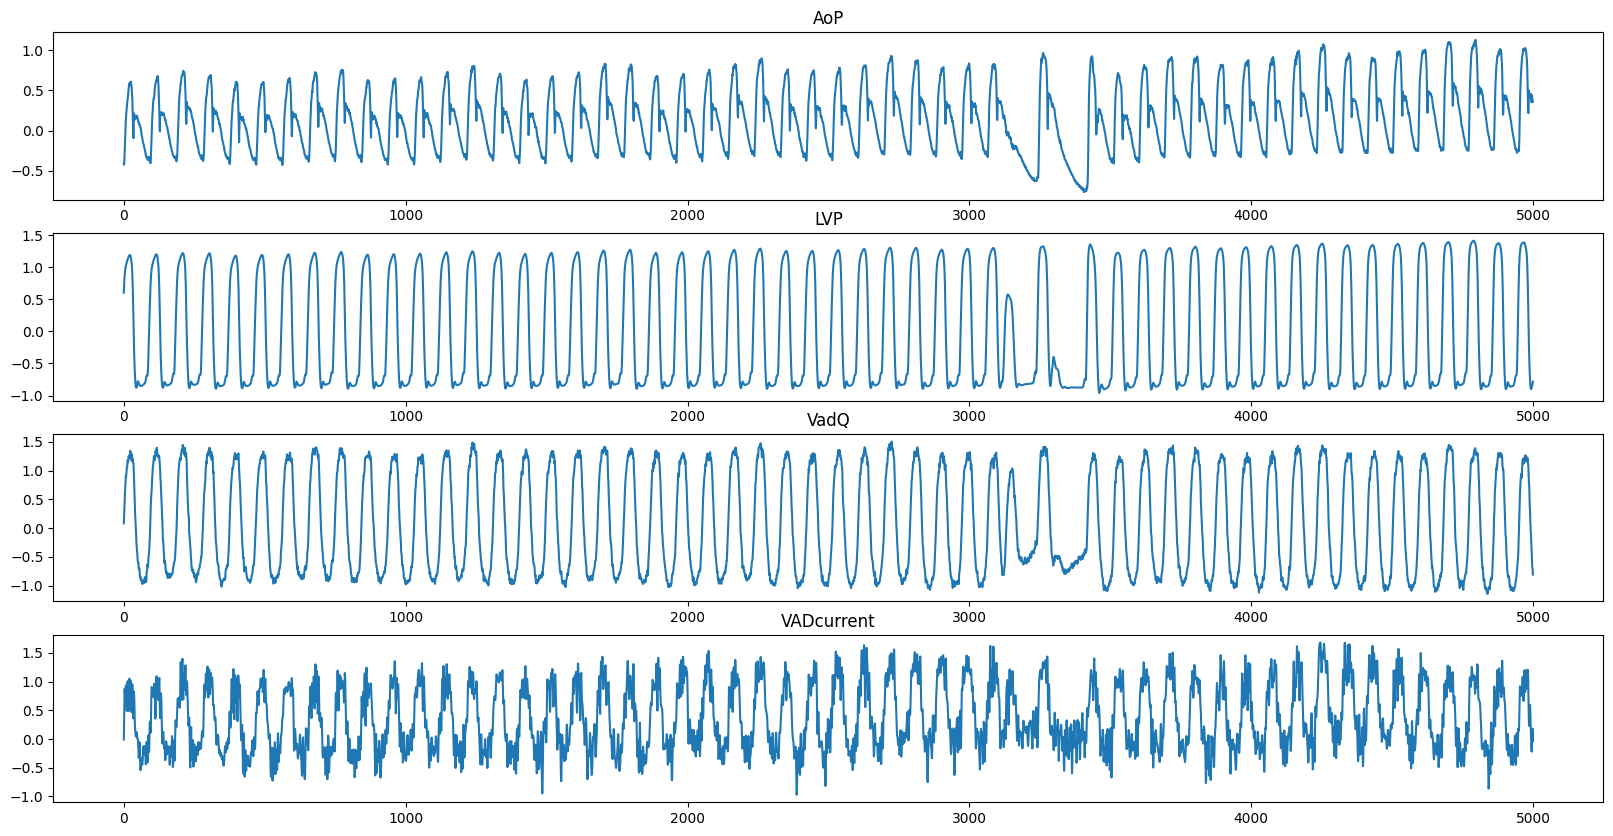

In [8]:
#plot AoP, LVP, VadQ, VADcurrent in different plots
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
axs[0].plot(df['AoP'][:5000])
axs[0].set_title('AoP')
axs[1].plot(df['LVP'][:5000])
axs[1].set_title('LVP')
axs[2].plot(df['VadQ'][:5000])
axs[2].set_title('VadQ')
axs[3].plot(df['VADcurrent'][:5000])
axs[3].set_title('VADcurrent')
plt.show()

### Split data into train and test split

In [9]:
# hom many different intervention ids are there?
print('\nDifferent interventions: \n',df['intervention'].unique())

# hom many different animal ids are there?
print('\nDifferent animal IDs: \n',len(df['animal'].unique()))

# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('\nDifferent animal IDs after removing those with less than 10 data points: \n',len(df['animal'].unique()))

# length of data per animal
#print(df.groupby('animal').size())

all_animals = df['animal'].unique()
# pick 2 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=1).unique()

# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animals:', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: \n',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

#print('Unique animals in df_train: ',df_train['animal'].unique())
#print('Unique animals in df_test: ',df_test['animal'].unique())

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Different interventions: 
 [10  3  1]

Different animal IDs: 
 6

Different animal IDs after removing those with less than 10 data points: 
 6

Test animals: [17]

Different animal IDs after removing those that are in the test dataset: 
 5

Train data shape: (677630, 13)

Test data shape: (134400, 13)

The test dataset is 16.55111264362154 percent of the whole data: 


In [ ]:
# # hom many different animal ids are there?
# print('Different animal IDs',df['animal'].unique())

# # hom many different intervention ids are there?
# print('Different interventions',df['intervention'].unique())

# # length of data per animal
# print(df.groupby('animal').size())

# # randomly pick one animal as test data
# test_animal = df['animal'].sample(n=1, random_state=1).iloc[0]
# print('Test animal:', test_animal)
# # test data
# df_test = df[df['animal'] == test_animal]

# # train data
# train = df[df['animal'] != test_animal]
# print('Train data shape:', train.shape)
# print('Test data shape:', df_test.shape)
# #print('The test data is {} percent of the whole data'.format(100/train.shape[0]*test.shape[0]))

# df_train = train
# print('Unique animals in df_train: ',train['animal'].unique())
# print('Unique animals in df_test: ',df_test['animal'].unique())

# # lengt of df_train
# print('The test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))

In [10]:
# create gen_dataset which is a part of the test dataset
df_gen = df_test.sample(frac=0.01, random_state=1)
print('\nGen data shape:', df_gen.shape)


Gen data shape: (1344, 13)


### create a combined tensor of SIG_A and SIG_B

In [11]:
# create a combined tensor of SIG_A and SIG_B
df_A = df[SIG_A]
df_B = df[SIG_B]
#print(df_A.head)
#print(df_B.head)

df_A = df_A.to_numpy()
df_B = df_B.to_numpy()

# split df_A into a 2D array 
df_A = np.split(df_A, df_A.shape[0], axis=0)
df_B = np.split(df_B, df_B.shape[0], axis=0)

# create a combined tensor of df_A and df_B
combined = np.concatenate((df_A, df_B), axis=1)
# to dataframe
combined = pd.DataFrame(combined, columns = [SIG_A, SIG_B])
print(combined.head)
print(combined.shape)

<bound method NDFrame.head of              AoP      VadQ
0      -0.411646  0.081215
1      -0.426329  0.216716
2      -0.374150  0.371777
3      -0.284682  0.472694
4      -0.202937  0.591993
...          ...       ...
812025 -0.360511  0.916076
812026 -0.270865  1.018153
812027 -0.169862  1.058696
812028 -0.075839  1.085585
812029  0.003428  1.220299

[812030 rows x 2 columns]>
(812030, 2)


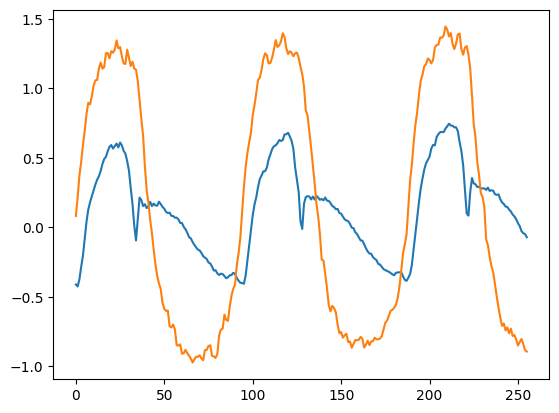

In [12]:
# plot the combined tensor in a single plot

plt.plot(combined[SIG_A][:256])
plt.plot(combined[SIG_B][:256])
plt.show()


In [13]:
print(df_A[:5])
print(df_B[:5])

[array([-0.4116459]), array([-0.42632928]), array([-0.37415017]), array([-0.28468183]), array([-0.20293728])]
[array([0.08121478]), array([0.21671624]), array([0.37177692]), array([0.47269357]), array([0.59199307])]


### Dataset loader

In [14]:
# Data should be of shape (Batch, channels = 2, Hight = 1, Width = 256)
# Test Dataset includes data from a single animal

class TrainDataset(Dataset):
    def __init__(self, signal_A, signal_B, target,  df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]
        self.target = self.df[target]

        # length should be modulo 256 = 0
        self.df = self.df.iloc[:-(len(self.df) % 256), :]

        # creating tensor from df 
        tensor_A = torch.tensor(self.df[signal_A].values)
        tensor_B = torch.tensor(self.df[signal_B].values)
        tensor_target = torch.tensor(self.df[target].values)

        # split tensor into tensors of size 256
        tensor_A = tensor_A.split(256)  # tensor shape (256, 1) 
        tensor_B = tensor_B.split(256)   
        tensor_target = tensor_target.split(256)    

        # stack tensors
        self.tensor_A = torch.stack(tensor_A).unsqueeze(1) 
        self.tensor_B = torch.stack(tensor_B).unsqueeze(1) 
        self.tensor_target = torch.stack(tensor_target).unsqueeze(1)
        # print(self.tensor_A.shape, self.tensor_A.shape)

        self.tensor_A = self.tensor_A.unsqueeze(1)
        self.tensor_B = self.tensor_B.unsqueeze(1)
        self.tensor_target =self.tensor_target.unsqueeze(1)


    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index], self.tensor_target[index]

In [15]:
class TestDataset(Dataset):
    def __init__(self, signal_A, signal_B, target,  df):
        self.df = df
        self.signal_A = self.df[signal_A]
        self.signal_B = self.df[signal_B]
        self.target = self.df[target]

        # length should be modulo 256 = 0
        #self.df = self.df.iloc[:-(len(self.df) % 256), :]
        #print(self.df.shape)
        # creating tensor from df 
        tensor_A = torch.tensor(self.df[signal_A].values)
        tensor_B = torch.tensor(self.df[signal_B].values)
        tensor_target = torch.tensor(self.df[target].values)

        # split tensor into tensors of size 256
        tensor_A = tensor_A.split(256)  # tensor shape (256, 1) 
        tensor_B = tensor_B.split(256)   
        tensor_target = tensor_target.split(256)    

        # stack tensors
        self.tensor_A = torch.stack(tensor_A).unsqueeze(1) 
        self.tensor_B = torch.stack(tensor_B).unsqueeze(1) 
        self.tensor_target = torch.stack(tensor_target).unsqueeze(1)
        # print(self.tensor_A.shape, self.tensor_A.shape)

        self.tensor_A = self.tensor_A.unsqueeze(1)
        self.tensor_B = self.tensor_B.unsqueeze(1)
        self.tensor_target =self.tensor_target.unsqueeze(1)


    def __len__(self):
        # signal_A and signal_B should have the same length
        return len(self.tensor_A)

    def __getitem__(self, index):
        # return the signal at the given index  # add data augmentation?
        return self.tensor_A[index], self.tensor_B[index], self.tensor_target[index]

In [16]:
print(len(df_test))
print(len(df_train))

134400
677630


In [17]:
SIG_A =  "VadQ" # "LVP"  
SIG_B = "AoP"
TARGET =  "LVtot_kalibriert" 

# Datasets
train_dataset = TrainDataset(signal_A=SIG_A, signal_B=SIG_B, target= TARGET, df=df_train)
test_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, target= TARGET, df=df_test)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=10, pin_memory=True,)

# length of train and test dataset
print(len(train_dataset), len(test_dataset))

2646 525


## Discriminator

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels= 2, out_channels= 32, kernel_size = 3, stride = 2, padding =1)
        self.conv2 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size = 3, stride = 2, padding =1)
        self.conv3 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size = 3, stride = 2, padding =1)
        self.conv4 = nn.Conv2d(in_channels= 128, out_channels= 1, kernel_size = 3, stride = 2, padding =1)
        
        self.out = nn.Sigmoid()


    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = self.conv5(x)
        #x = self.conv6(x)
        x = self.out(x)
        return x
    
x1 = torch.rand(512, 1, 1, 256)
x2 = torch.rand(512, 1, 1, 256)
combined_input = torch.cat((x1, x2), dim=1)
print(combined_input.shape)
discriminator = Discriminator()
print(discriminator(combined_input).shape)

torch.Size([512, 2, 1, 256])
torch.Size([512, 1, 1, 16])


## Generator

In [19]:
def double_conv_pad(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
        nn.LeakyReLU(inplace=True)
    )

class Two_channel_UnetGenerator(nn.Module):
    def __init__(self):
        super(Two_channel_UnetGenerator, self).__init__()
        self.maxpool = nn.MaxPool2d((1,2))

        self.down_conv1 = double_conv_pad(2, 32) 
        self.down_conv2 = double_conv_pad(32, 64) 
        self.down_conv3 = double_conv_pad(64, 128)
        self.down_conv4 = double_conv_pad(128, 256)

        self.up_trans1 = nn.ConvTranspose2d(256, 128, kernel_size=(1,2), stride=2, padding=0)
        self.up_conv1 = double_conv_pad(128, 128)
        self.up_trans2 = nn.ConvTranspose2d(128, 64, kernel_size=(1,2), stride=2, padding=0)
        self.up_conv2 = double_conv_pad(64, 64)
        self.up_trans3 = nn.ConvTranspose2d(64, 32, kernel_size=(1,2), stride=2, padding=0)
        self.up_conv3 = double_conv_pad(32, 32)

        self.out = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, input_A, input_B):
        # [Batch size, Channels in, Height, Width]
        #print("Downsamnpling")
        #print("Input sizes: ", input_A.size(), input_B.size())
        x1 = self.down_conv1(torch.cat([input_A, input_B], 1))
        # print(x1.size())  
        x2 = self.maxpool(x1) 
        # print(x2.size())
        x3 = self.down_conv2(x2)  #
        # print(x3.size())
        x4 = self.maxpool(x3) 
        # print(x4.size()) 
        x5 = self.down_conv3(x4)  #
        # print(x5.size()) 
        x6 = self.maxpool(x5)
        # print(x6.size())  
        x7 = self.down_conv4(x6)
        # print(x7.size())

        # # decoder
        # print("Upsampling")
        x = self.up_trans1(x7)
        # print(x.size())
        x = self.up_conv1(x)
        x = self.up_trans2(x)
        # print(x.size())
        x = self.up_conv2(x)
        x = self.up_trans3(x)
        # print(x.size())
        x = self.up_conv3(x)
        x = self.out(x)
        return x
    
x1 = torch.rand(512, 1, 1, 256)
x2 = torch.rand(512, 1, 1, 256)

# x1 = torch.rand(512, 1, 256)
# x2 = torch.rand(512, 1, 256)
model = Two_channel_UnetGenerator()
print(model(x1, x2).shape)

torch.Size([512, 1, 1, 256])


## Training

/tmp/ipykernel_4231/4182299862.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_train[SIG_A][:1000], label= SIG_A)
/tmp/ipykernel_4231/4182299862.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_train[SIG_B][:1000], label= SIG_B)
/tmp/ipykernel_4231/4182299862.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i

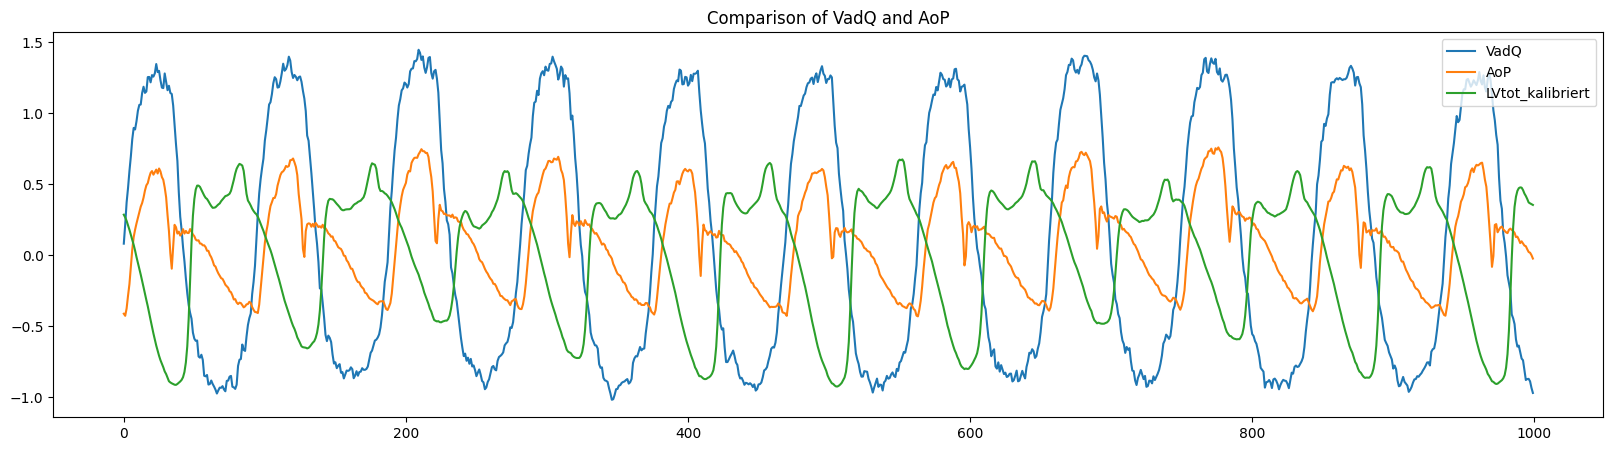

In [20]:
# Visualize the data we want to generate
plt.figure(figsize=(20, 5))
plt.plot(df_train[SIG_A][:1000], label= SIG_A)
plt.plot(df_train[SIG_B][:1000], label= SIG_B)
plt.plot(df_train[TARGET][:1000], label= TARGET)
plt.title('Comparison of {} and {}'.format(SIG_A, SIG_B))
plt.legend()
plt.show()

In [36]:
# initialize generator and discriminator
gen_source = Two_channel_UnetGenerator().to(DEVICE)
gen_target = Two_channel_UnetGenerator().to(DEVICE)
disc_source = Discriminator().to(DEVICE)
disc_target = Discriminator().to(DEVICE)

# optimizers for discriminator and generator 
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# scheduler
gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = 1,
                                                    )
disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = 1,
                                                    )

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

l1 = nn.L1Loss() # L1 loss for cycle consistency and identity loss
mse = nn.MSELoss() # MSE loss for adversarial loss

# create datasets 
dataset = TrainDataset(signal_A=SIG_A, signal_B=SIG_B, target=TARGET, df=df_train)
test_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, target=TARGET, df=df_test)
#gen_dataset = TestDataset(signal_A=SIG_A, signal_B=SIG_B, target=TARGET, df=df_gen)  

# Data loader
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
#gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)

# run in float16
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_losses = {
            'Discrminator source loss' : [],
            'Discrminator target loss' : [],
            'Total Discrminator loss' : [],
            'Adversaral loss source' : [],
            'Adversaral loss target' : [],
            'Cycle consistency loss source' : [],
            'Cycle consistency loss target' : [],
            'Total Generator loss' : [],
        }

test_losses = {
            'Discrminator source loss' : [],
            'Discrminator target loss' : [],
            'Total Discrminator loss' : [],
            'Adversaral loss source' : [],
            'Adversaral loss target' : [],
            'Cycle consistency loss source' : [],
            'Cycle consistency loss target' : [],
            'Total Generator loss' : [],
            'L1 loss between real source signal and fake source signals' : [],
            'L1 loss between real target signal and fake target signals' : [],
        }

B_reals = 0
B_fakes = 0

In [37]:
# training loop

for epoch in range(NUM_EPOCHS):

    for sig_A, sig_B, target in loader:
        # convert to float16
        sig_A = sig_A.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        sig_B = sig_B.float() # and weight type (torch.cuda.HalfTensor) should be the same"
        target = target.float()
        
        # move to GPU
        sig_A = sig_A.to(DEVICE)
        sig_B = sig_B.to(DEVICE)
        target = target.to(DEVICE)

        #  -------------------------------- #
        #  ----- train discriminators ----- #
        #  -------------------------------- #
        with torch.cuda.amp.autocast(): 
            fake_target = gen_target(sig_A, sig_B) # generate fake target signal
            d_target_real = disc_target(torch.cat([sig_A, sig_B], 1).to(DEVICE)) # output of discriminator target for real target signal
            
            # combine fake target signal with zeros to match the input size of the discriminator
            dummy_tensor = torch.zeros(len(sig_A), 1, 1, 256).to(DEVICE)
            combined_fake_target = torch.cat([fake_target.detach(), dummy_tensor], 1).to(DEVICE)
            d_target_fake = disc_target(combined_fake_target) # output of discriminator target for fake target signal 
                
            B_reals += d_target_real.mean().item()
            B_fakes += d_target_fake.mean().item()

            # Loss between dicriminator (with real signal) output and 1 - The discriminator should output 1 for real signals
            d_target_real_loss = mse(d_target_real, torch.ones_like(d_target_real))  
            # Loss between dicriminator (with fake signal) output and 0 - The discriminator should output 0 for fake signals
            d_target_fake_loss = mse(d_target_fake, torch.zeros_like(d_target_fake)) 
            # Total loss for discriminator B
            d_target_loss = d_target_real_loss + d_target_fake_loss

        
            fake_source = gen_source(target, dummy_tensor) # generate fake source signal
            combined_true_signals = torch.cat([sig_A, sig_B], 1).to(DEVICE)
            d_source_real = disc_source(combined_true_signals) # output of discriminator source for real source signal
            
            combined_fake_source= torch.cat([fake_source, dummy_tensor], 1).to(DEVICE)
            d_source_fake = disc_source(combined_fake_source.detach()) 

            d_source_real_loss = mse(d_source_real, torch.ones_like(d_source_real)) 
            d_source_fake_loss = mse(d_source_fake, torch.zeros_like(d_source_fake))  
            d_source_loss = d_source_real_loss + d_source_fake_loss

            # Total loss for discriminator A
            d_loss = d_source_loss + d_target_loss  # in cycle GAN paper they halve the loss

        # exit amp.auto_cast() context manager and backpropagate 
        opt_disc.zero_grad() 
        d_scaler.scale(d_loss).backward()  
        d_scaler.step(opt_disc)  
        d_scaler.update()


        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 
        with torch.cuda.amp.autocast():

            # ----- adversarial loss for both generators ----- #
            d_source_fake = disc_source(combined_fake_source) # disc_source should output 0 for fake source signal 
            d_target_fake = disc_target(combined_fake_target) # disc_target should output 0 for fake target signal
            # loss between discriminator output and 0 - The discriminator should output 0 for fake signals
            g_source_loss = mse(d_source_fake, torch.zeros_like(d_source_fake)) # was ones_like before  
            g_target_loss = mse(d_target_fake, torch.zeros_like(d_target_fake)) # was ones_like before

            # ----- cycle consistency loss ----- #
            cycle_target = gen_target(fake_source, dummy_tensor)  
            cycle_source = gen_source(fake_target, dummy_tensor) # fake_B = gen_A2B(sig_A)
            cycle_target_loss = l1(sig_B, cycle_target)  # l1 loss: Mean absolute error between each element in the input x and target y.
            cycle_source_loss = l1(sig_A, cycle_source)


            # put it all together
            g_loss = (
                g_source_loss +
                g_target_loss +
                cycle_target_loss * LAMBDA_CYCLE +
                cycle_source_loss * LAMBDA_CYCLE 
            )

        # update gradients of generator
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward() 
        g_scaler.step(opt_gen) 
        g_scaler.update()

    # save losses
    train_losses['Discrminator source loss'].append(d_source_loss.item())
    train_losses['Discrminator target loss'].append(d_target_loss.item())
    train_losses['Total Discrminator loss'].append(d_loss.item())
    train_losses['Adversaral loss source'].append(g_source_loss.item())
    train_losses['Adversaral loss target'].append(g_target_loss.item())
    train_losses['Cycle consistency loss source'].append(cycle_source_loss.item())
    train_losses['Cycle consistency loss target'].append(cycle_target_loss.item())
    train_losses['Total Generator loss'].append(g_loss.item())  

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    #  validation every 10 epochs
    if (epoch+1) % 1 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_source.eval()  # set discriminator to evaluation mode
            disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_target.eval()
            gen_source.eval()

            # store losses for testing
            test_Discrminator_source_loss = 0 #
            test_Discrminator_target_loss = 0 #
            test_Total_Discrminator_loss = 0 #
            test_Adversaral_loss_source = 0  #
            test_Adversaral_loss_target = 0  #
            test_Cycle_consistency_loss_source = 0 #
            test_Cycle_consistency_loss_target = 0 #
            test_Total_Generator_loss = 0 #
            test_L1_real_fake_source = 0  # L1 loss between real signal A and fake signal A
            test_L1_real_fake_target = 0  # L1 loss between real signal B and fake signal B

            for sig_A, sig_B, target in test_loader:
                # convert to float16
                sig_A = sig_A.float()
                sig_B = sig_B.float()
                target = target.float()
                # move to GPU
                sig_A = sig_A.to(DEVICE)
                sig_B = sig_B.to(DEVICE)
                target = target.to(DEVICE)

                dummy_tensor = torch.zeros(len(sig_A), 1, 1, 256).to(DEVICE)
                fake_target = gen_target(sig_A, sig_B)
                fake_source = gen_source(target, dummy_tensor)
        
                # calculate l1 loss of fake signals and real signals
                test_L1_real_fake_target = l1(target, fake_target)
                test_L1_real_fake_source = l1(torch.cat([sig_A, sig_B], 1), fake_source)  # maybe switch sig_A and sig_B

                # calculate adversarial loss
                dummy_fake_target = torch.zeros(len(fake_target), 1, 1, 256).to(DEVICE)  # torch.Size([512, 1, 1, 256])
                
                disc_target_fake_target = disc_target(torch.cat([fake_target, dummy_fake_target],1))
                disc_source_fake_source = disc_source(torch.cat([fake_source, dummy_tensor],1))
                test_Adversaral_loss_target = mse(disc_target_fake_target, torch.zeros_like(disc_target_fake_target)) #was ones_like before
                test_Adversaral_loss_source = mse(disc_source_fake_source, torch.zeros_like(disc_source_fake_source))

                # ----- cycle loss ----- #
                cycle_target = gen_target(fake_source, dummy_tensor)  
                cycle_source = gen_source(fake_target, dummy_tensor)  
                test_Cycle_consistency_loss_target = l1(target, cycle_target)
                test_Cycle_consistency_loss_source = l1(torch.cat([sig_A, sig_B], 1), cycle_source)

                # ----- discriminator loss ----- #
                source = torch.cat([sig_A, sig_B], 1) # torch.Size([512, 2, 1, 256])
                # print(disc_source(source).shape)  torch.Size([512, 1, 1, 16])
                #print(fake_source.shape)   # torch.Size([512, 1, 1, 256])
                dummy = torch.zeros(len(fake_source), 1, 1, 256).to(DEVICE)
                cat = torch.cat([fake_source, dummy], 1) 
                cat_target = torch.cat([target, dummy], 1).to(DEVICE)
                cat_fake_target = torch.cat([fake_target, dummy], 1).to(DEVICE)
                # print(disc_target(torch.cat([target, dummy], 1)).shape)   # torch.Size([512, 1, 1, 16])
                test_Discrminator_source_loss = mse(disc_source(source), torch.ones_like(disc_source(source))) + mse(disc_source(cat), torch.zeros_like(disc_source(cat)))
                
                # mse(disc_target(cat_target), torch.ones_like(disc_target(cat_target)))
                # mse(disc_target(cat_fake_target), torch.zeros_like(disc_target(cat_fake_target)))

                test_Discrminator_target_loss = mse(disc_target(cat_target), torch.ones_like(disc_target(cat_target))) + mse(disc_target(cat_fake_target), torch.zeros_like(disc_target(cat_fake_target)))
                
                # ----- total generator loss ----- #
                test_Total_Generator_loss = test_Adversaral_loss_source + test_Adversaral_loss_target + test_Cycle_consistency_loss_target + test_Cycle_consistency_loss_source 
                
                # ----- total discriminator loss ----- #
                test_Total_Discrminator_loss = test_Discrminator_source_loss + test_Discrminator_target_loss

                # save losses
                test_losses['Discrminator source loss'].append(test_Discrminator_source_loss.item())
                test_losses['Discrminator target loss'].append(test_Discrminator_target_loss.item())
                test_losses['Total Discrminator loss'].append(test_Total_Discrminator_loss.item())
                test_losses['Adversaral loss source'].append(test_Adversaral_loss_source.item())
                test_losses['Adversaral loss target'].append(test_Adversaral_loss_target.item())
                test_losses['Cycle consistency loss source'].append(test_Cycle_consistency_loss_source.item())
                test_losses['Cycle consistency loss target'].append(test_Cycle_consistency_loss_target.item())
                test_losses['Total Generator loss'].append(test_Total_Generator_loss.item())
                test_losses['L1 loss between real source signal and fake source signals'].append(test_L1_real_fake_source.item())
                test_losses['L1 loss between real target signal and fake target signals'].append(test_L1_real_fake_target.item())

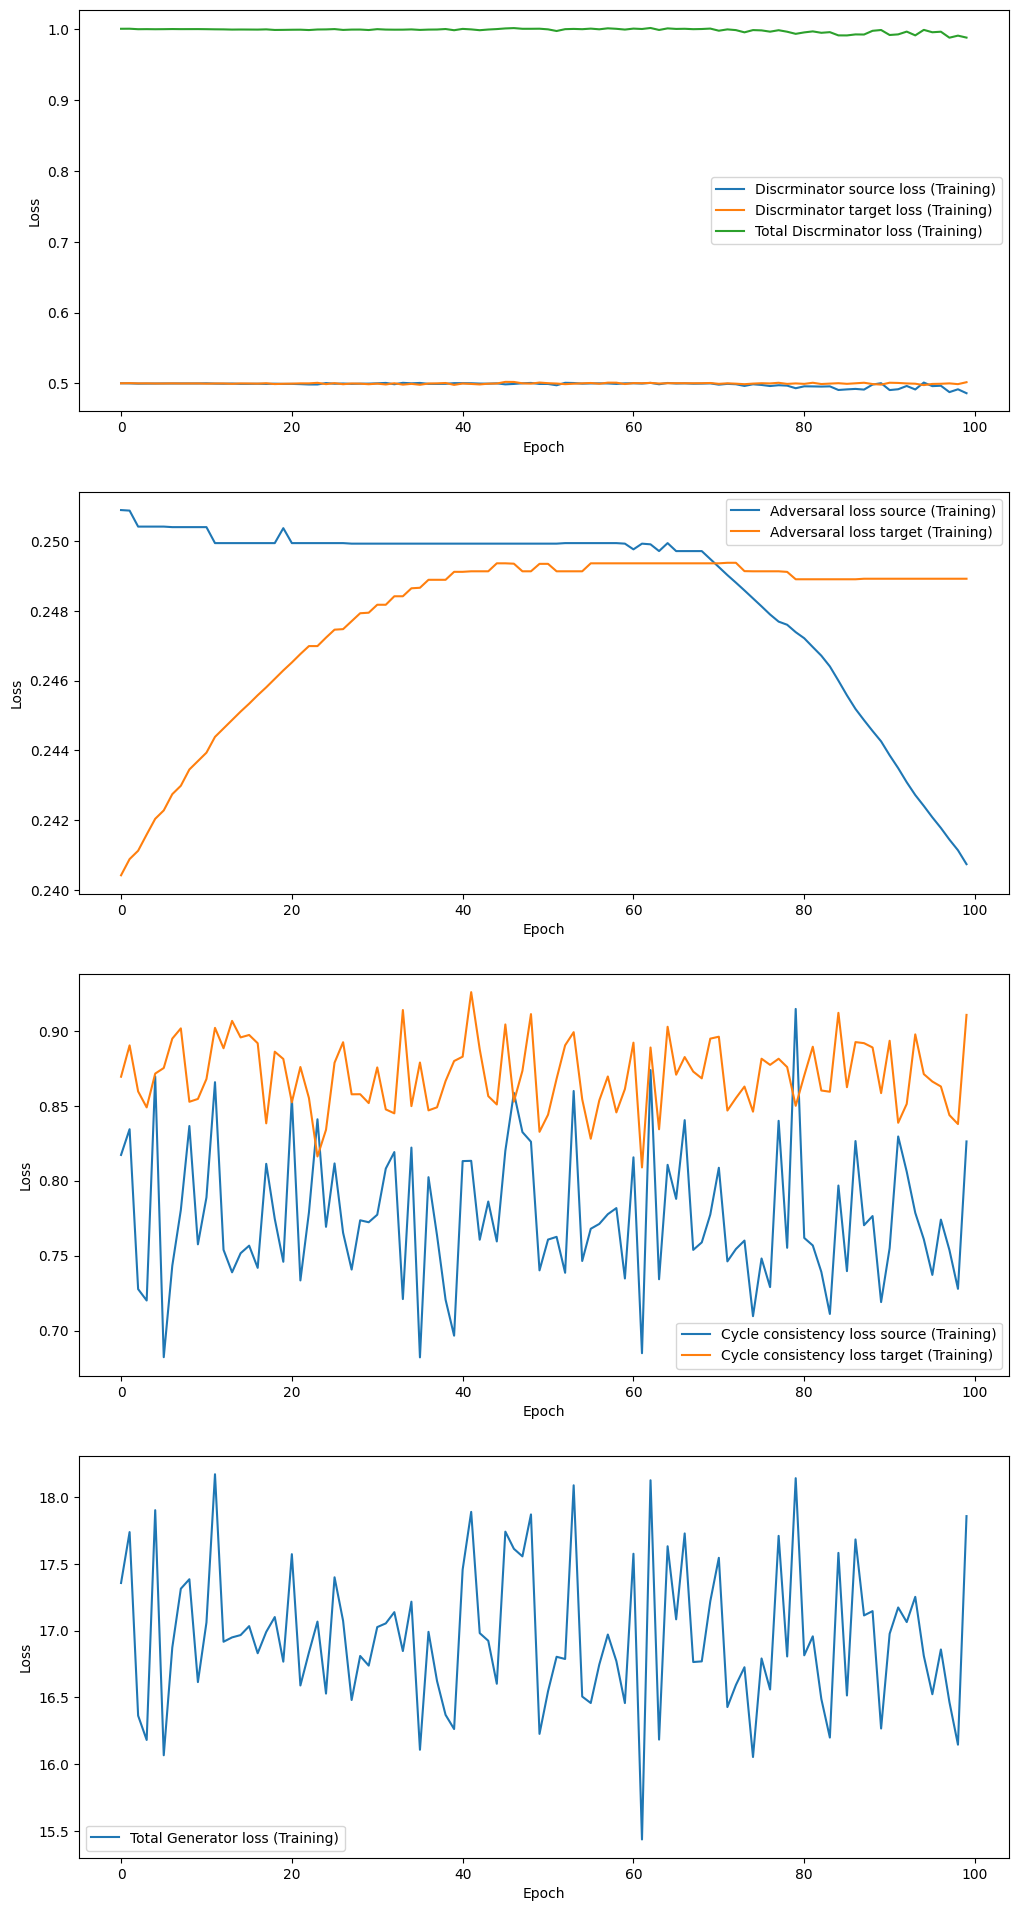

In [33]:
# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# Plot training losses in different subplots

fig, ax = plt.subplots(4, 1, figsize=(12, 24))
ax[0].plot(train_losses['Discrminator source loss'], label= 'Discrminator source loss (Training)')
ax[0].plot(train_losses['Discrminator target loss'], label= 'Discrminator target loss (Training)')
ax[0].plot(train_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Training)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[0].set_title('Training Discriminator Loss')

ax[1].plot(train_losses['Adversaral loss source'], label= 'Adversaral loss source (Training)')
ax[1].plot(train_losses['Adversaral loss target'], label= 'Adversaral loss target (Training)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
#ax[1].set_title('Training Adversarial Loss')
ax[2].plot(train_losses['Cycle consistency loss source'], label= 'Cycle consistency loss source (Training)')
ax[2].plot(train_losses['Cycle consistency loss target'], label= 'Cycle consistency loss target (Training)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
#ax[2].set_title('Training Cycle Consistency Loss')
ax[3].plot(train_losses['Total Generator loss'], label= 'Total Generator loss (Training)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()

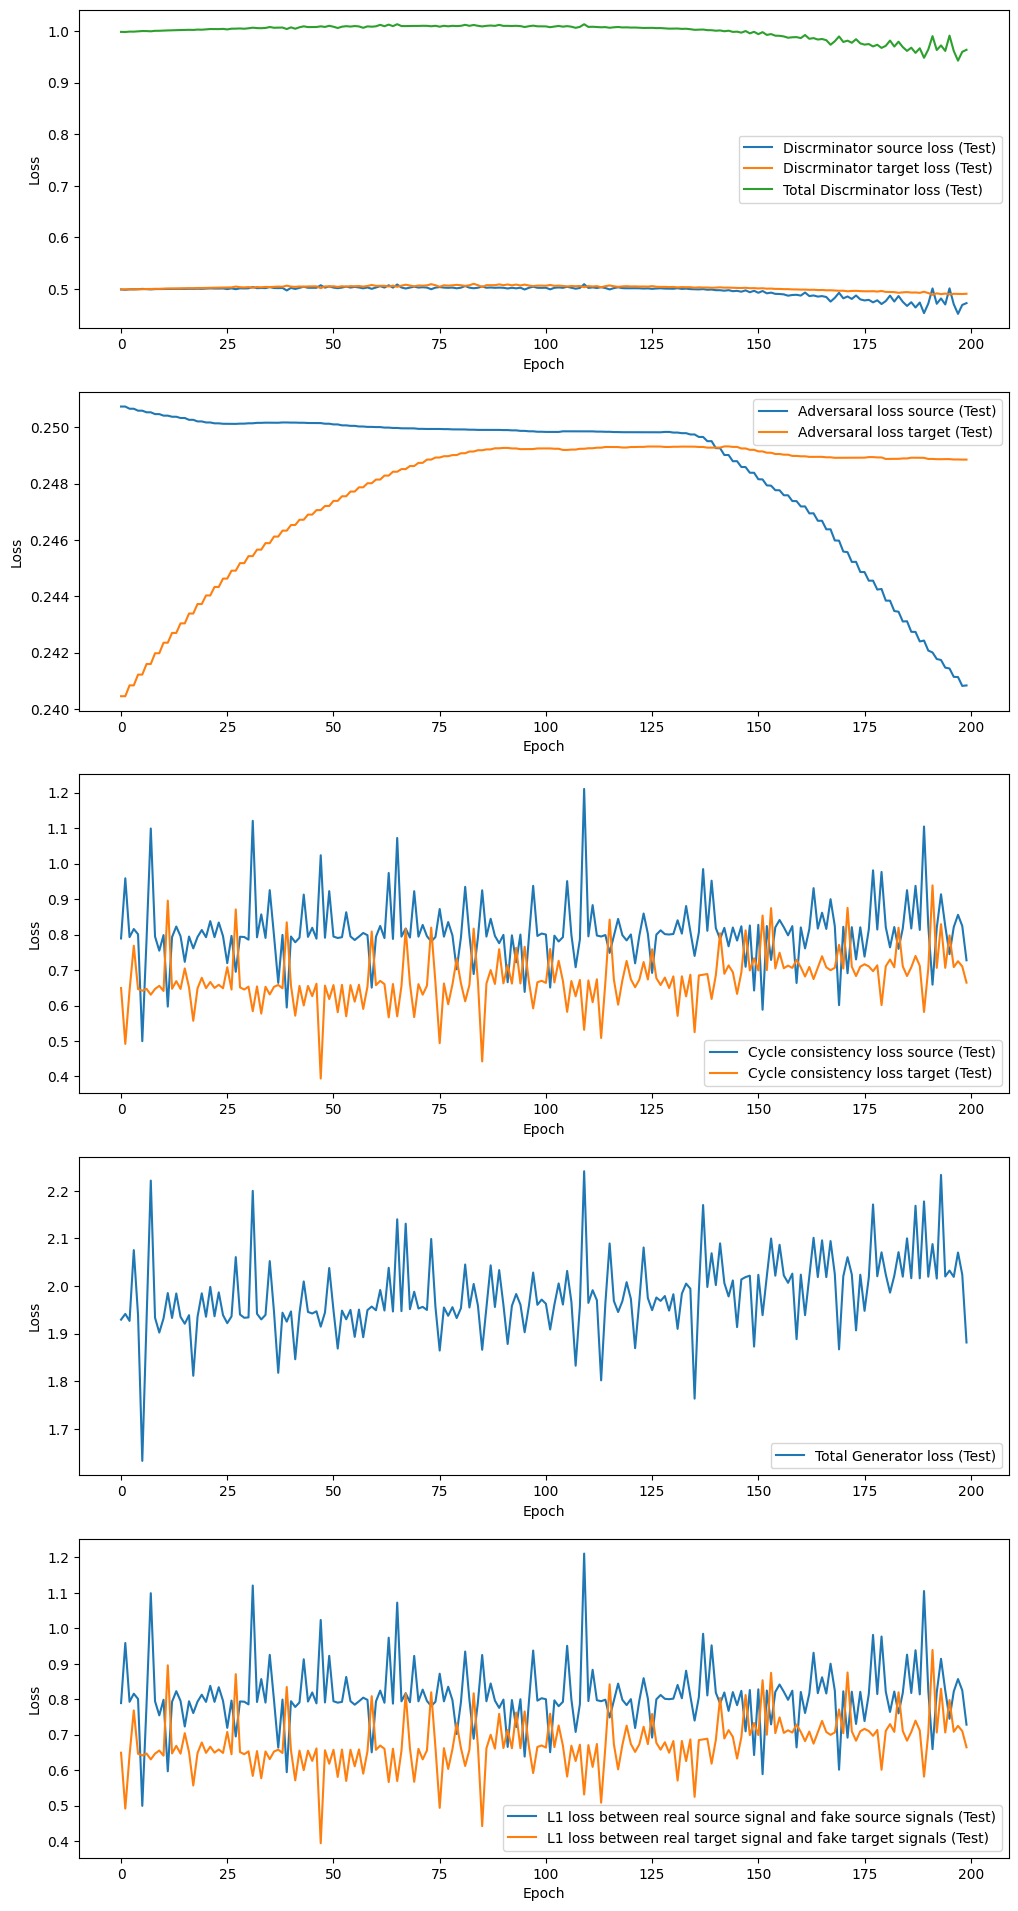

In [34]:
fig, ax = plt.subplots(5, 1, figsize=(12, 24))
ax[0].plot(test_losses['Discrminator source loss'], label= 'Discrminator source loss (Test)')
ax[0].plot(test_losses['Discrminator target loss'], label= 'Discrminator target loss (Test)')
ax[0].plot(test_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Test)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[4].set_title('Test Discriminator Loss')

ax[1].plot(test_losses['Adversaral loss source'], label= 'Adversaral loss source (Test)')
ax[1].plot(test_losses['Adversaral loss target'], label= 'Adversaral loss target (Test)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
#ax[5].set_title('Test Adversarial Loss')

ax[2].plot(test_losses['Cycle consistency loss source'], label= 'Cycle consistency loss source (Test)')
ax[2].plot(test_losses['Cycle consistency loss target'], label= 'Cycle consistency loss target (Test)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
#ax[6].set_title('Test Cycle Consistency Loss')

ax[3].plot(test_losses['Total Generator loss'], label= 'Total Generator loss (Test)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
#ax[7].set_title('Test Total Generator Loss')

ax[4].plot(test_losses['L1 loss between real source signal and fake source signals'], label= 'L1 loss between real source signal and fake source signals (Test)')
ax[4].plot(test_losses['L1 loss between real target signal and fake target signals'], label= 'L1 loss between real target signal and fake target signals (Test)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend()

In [ ]:
            #  ------------------------------------- #   
            #  ------- Generate fake signals ------- #
            #  ------------------------------------- #
            
            # Generate fake signals after the last epoch
            
            if (epoch+1) % GENERATION_AFTER_EPOCH == 0:
                print('Generate fake signals')
                # generate fake signals 10 times
                #utils.save_predictions(gen_loader, gen_B, gen_A, fake_A, fake_B, DEVICE, mse)

                for sig_A, sig_B in gen_loader:
                    
                    sig_A = sig_A.float()
                    sig_B = sig_B.float()
                    sig_A = sig_A.to(DEVICE)
                    sig_B = sig_B.to(DEVICE)

                    fake_B = gen_B(sig_A)
                    fake_A = gen_A(sig_B)

                    # plot generated signals and real signals
                    #reshape to 1D
                    fake_B = fake_B.reshape(-1)
                    fake_A = fake_A.reshape(-1)
                    sig_A = sig_A.reshape(-1)
                    sig_B = sig_B.reshape(-1)

                    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
                    ax[0].plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
                    ax[0].plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
                    ax[0].set_xlabel('Epoch')
                    ax[0].set_ylabel('Loss')
                    ax[0].legend()

                    ax[1].plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
                    ax[1].plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
                    ax[1].set_xlabel('Epoch')
                    ax[1].set_ylabel('Loss')
                    ax[1].legend()

                    # plot generated signals and real signals
                    # plt.figure(figsize=(20, 5))
                    # plt.plot(sig_A.cpu().detach().numpy(), label= 'Real signal A')
                    # plt.plot(sig_B.cpu().detach().numpy(), label= 'Real signal B')
                    # plt.plot(fake_A.cpu().detach().numpy(), label= 'Generated signal A')
                    # plt.plot(fake_B.cpu().detach().numpy(), label= 'Generated signal B')
                    # plt.title('Generated signals vs real signals')
                    # plt.legend()

                        
                    # save generated signals
                    # utils.save_predictions(sig_A, sig_B, fake_A, fake_B, epoch, mse, l1, DEVICE)

        # activate training mode again
        disc_A.train()  
        disc_B.train()
        gen_B.train()
        gen_A.train()

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()
        
# ----------------------------------- #
# -------------- PLOT --------------- #
# ----------------------------------- #

# Plot training losses in different subplots

fig, ax = plt.subplots(9, 1, figsize=(12, 24))
ax[0].plot(train_losses['Discrminator A loss'], label= 'Discrminator A loss (Training)')
ax[0].plot(train_losses['Discrminator B loss'], label= 'Discrminator B loss (Training)')
ax[0].plot(train_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Training)')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
#ax[0].set_title('Training Discriminator Loss')

ax[1].plot(train_losses['Adversaral loss A'], label= 'Adversaral loss A (Training)')
ax[1].plot(train_losses['Adversaral loss B'], label= 'Adversaral loss B (Training)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
#ax[1].set_title('Training Adversarial Loss')
ax[2].plot(train_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Training)')
ax[2].plot(train_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Training)')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()
#ax[2].set_title('Training Cycle Consistency Loss')
ax[3].plot(train_losses['Total Generator loss'], label= 'Total Generator loss (Training)')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Loss')
ax[3].legend()
#ax[3].set_title('Training Total Generator Loss')

# Plot test losses in different subplots

ax[4].plot(test_losses['Discrminator A loss'], label= 'Discrminator A loss (Test)')
ax[4].plot(test_losses['Discrminator B loss'], label= 'Discrminator B loss (Test)')
ax[4].plot(test_losses['Total Discrminator loss'], label= 'Total Discrminator loss (Test)')
ax[4].set_xlabel('Epoch')
ax[4].set_ylabel('Loss')
ax[4].legend()
#ax[4].set_title('Test Discriminator Loss')

ax[5].plot(test_losses['Adversaral loss A'], label= 'Adversaral loss A (Test)')
ax[5].plot(test_losses['Adversaral loss B'], label= 'Adversaral loss B (Test)')
ax[5].set_xlabel('Epoch')
ax[5].set_ylabel('Loss')
ax[5].legend()
#ax[5].set_title('Test Adversarial Loss')

ax[6].plot(test_losses['Cycle consistency loss A'], label= 'Cycle consistency loss A (Test)')
ax[6].plot(test_losses['Cycle consistency loss B'], label= 'Cycle consistency loss B (Test)')
ax[6].set_xlabel('Epoch')
ax[6].set_ylabel('Loss')
ax[6].legend()
#ax[6].set_title('Test Cycle Consistency Loss')

ax[7].plot(test_losses['Total Generator loss'], label= 'Total Generator loss (Test)')
ax[7].set_xlabel('Epoch')
ax[7].set_ylabel('Loss')
ax[7].legend()
#ax[7].set_title('Test Total Generator Loss')

ax[8].plot(test_losses['L1 loss between real signal A and fake signals A'], label= 'L1 loss between real signal A and fake signals A (Test)')
ax[8].plot(test_losses['L1 loss between real signal B and fake signals B'], label= 'L1 loss between real signal B and fake signals B (Test)')
ax[8].set_xlabel('Epoch')
ax[8].set_ylabel('Loss')
ax[8].legend()
#ax[8].set_title('Test L1 Loss')

plt.show()

print('Selected losses for the test dataset after the last epoch:\n')
print('\nL1 loss between real signal A and fake signals A: ', test_losses['L1 loss between real signal A and fake signals A'][-1])
print('\nL1 loss between real signal B and fake signals B: ', test_losses['L1 loss between real signal B and fake signals B'][-1])
print('\nDiscrminator A loss: ', test_losses['Discrminator A loss'][-1])
print('\nDiscrminator B loss: ', test_losses['Discrminator B loss'][-1])
print('\nTotal Discriminator loss: ', test_losses['Total Discrminator loss'][-1])
print('\nAdversaral loss A: ', test_losses['Adversaral loss A'][-1])
print('\nAdversaral loss B: ', test_losses['Adversaral loss B'][-1])
print('\nCycle consistency loss A: ', test_losses['Cycle consistency loss A'][-1])
print('\nCycle consistency loss B: ', test_losses['Cycle consistency loss B'][-1])
print('\nTotal Generator loss: ', test_losses['Total Generator loss'][-1])


print('Training finished')